In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [1]:
!pip3 install matplotlib pandas seaborn

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.5 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 292 kB 4.7 MB/s eta 0:00:01
     |████████████████████████████████| 503 kB 7.3 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 1.9 MB/s eta 0:00:01     |███████████████                 | 12.1 MB 2.6 MB/s eta 0:00:06     |██████████████████████████      | 21.0 MB 8.1 MB/s eta 0:00:01     |██████████████████████████▋     | 21.5 MB 8.1 MB/s eta 0:00:01     |███████████████████████████▊    | 22.4 MB 8.1 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    sns.set(rc={'figure.figsize':(11.7, 5.27)})
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })
    
    sns.set_theme(style="ticks", palette="pastel")
    

set_style()

In [4]:
def parse_res(file, benchmark="not_provided"):
    try:
        with open(file, 'r') as f:
            lines = f.read().split("\n")
    except:
        print(f"{file} not found")
        return pd.DataFrame()
        
    data = []
    for line in lines:
        if line:
            try:
                script, time = line.split()
                if float(time) == 0.0:
                    raise Exception()
                sname = script.replace(".sh:", "")
                data.append([f"{sname}_{benchmark}", sname, float(time)])
            except:
                print(f"Skipping {line}")
    
    df = pd.DataFrame(data, columns=["uid", "benchname", "exec_time"])
    df = df.set_index("uid")
    return df

In [5]:
folder = 'original_config'

def average_dfs(dfs):
    df = pd.concat(dfs)
    df = df.groupby('bench_name').mean()
    return df

def get_summary_per_mode(benchmarks, modes):
    # Returns a list of lists where each sublist contains all modes results for a benchmarks
    all_benchs = []
    for benchmark in benchmarks:
        dfs = {}
        for mode in modes:
            df = parse_res(f'{folder}/{benchmark}/{mode}.res', benchmark)
            dfs[mode] = df
        all_benchs.append((benchmark, dfs))
        
    summary_per_mode = {}
    for mode in modes:
        summary = []
        for benchmark, dfs in all_benchs:
            dfs[mode]['benchmark'] = benchmark
            summary.append(dfs[mode])

        new_df = pd.concat(summary, axis = 0)
        new_df['mode'] = mode
        summary_per_mode[mode] = new_df
    return summary_per_mode


def remap_labels(df):
    remap = {'hadoopstreaming': "Hadoop-streaming", 'par': "PaSh", 'distr': "DiSh", "distr_no_du": "DiSh no du"}
    df['mode'] = df['mode'].map(remap)
    return df
    

def get_speedup_df(summary_per_mode):
    dfs = []
    for mode in summary_per_mode:
        if mode == 'seq':
            continue
        summary_per_mode[mode]['speedup'] = summary_per_mode['seq']['exec_time']/summary_per_mode[mode]['exec_time']
        summary_per_mode[mode].dropna()
        dfs.append(summary_per_mode[mode])
    summary_df = pd.concat(dfs, axis = 0)
    summary_df.dropna()
    
    return remap_labels(summary_df)



In [56]:
benchmarks = ["oneliners", "unix50", "nlp", "analytics-mts", "dependency_untangling", "max-temp"]
modes = ["distr", "par", "seq"]
summary_per_mode = get_summary_per_mode(benchmarks, modes)
summary_df = pd.concat(summary_per_mode, axis = 1)

# summary_df.to_csv("benchmarks.csv")  
def print_stats(df, baseline_mode, mode):
    speedup_df = pd.DataFrame()
    speedup_df['speedup'] = df[baseline_mode]['exec_time']/df[mode]['exec_time']
    speedup_df.dropna()
    print (f"{mode} speedup over {baseline_mode} stats:\n Mean {speedup_df['speedup'].mean()}, Max {speedup_df['speedup'].max()}, Min  {speedup_df['speedup'].min()}")
    
print_stats(summary_per_mode, "seq", "par")
# print_stats(summary_per_mode, "seq", "hadoopstreaming")
print_stats(summary_per_mode, "seq", "distr")

Skipping executing one-liners with distr pash with data Thu Jun 16 05:25:02 UTC 2022
Skipping executing one-liners with par pash with data Sat Jun 11 18:58:30 UTC 2022
Skipping executing one-liners Sat Jun 11 05:50:02 UTC 2022
Skipping executing Unix50 Sat Jun 11 21:36:29 UTC 2022
Skipping executing Unix50 Sat Jun 11 20:44:22 UTC 2022
Skipping executing Unix50 Sat Jun 11 11:24:13 UTC 2022
Skipping executing Unix-for-nlp with distr pash Sat Jun 11 22:54:28 UTC 2022
Skipping executing Unix-for-nlp with par pash Sat Jun 11 21:47:40 UTC 2022
Skipping executing Unix-for-nlp Sat Jun 11 14:01:48 UTC 2022
Skipping executing MTS analytics with pash Sat Jun 11 23:46:08 UTC 2022
Skipping executing MTS analytics with pash Sat Jun 11 23:24:33 UTC 2022
Skipping executing MTS analytics Sat Jun 11 23:01:15 UTC 2022
Skipping executing dependency_untangling with pash Sun Jun 12 01:40:37 UTC 2022
Skipping executing dependency_untangling with pash Sun Jun 12 01:02:11 UTC 2022
Skipping executing dependency

Skipping executing one-liners Sat Jun 11 05:50:02 UTC 2022
Skipping executing oneliners Thu Jun 16 06:16:43 UTC 2022
Skipping executing one-liners with par pash with data Sat Jun 11 18:58:30 UTC 2022
Skipping executing one-liners with distr pash with data Thu Jun 16 05:25:02 UTC 2022
Skipping executing Unix50 Sat Jun 11 11:24:13 UTC 2022
Skipping executing Unix50 Wed Jun 15 21:57:37 UTC 2022
Skipping executing Unix50 Sat Jun 11 20:44:22 UTC 2022
Skipping executing Unix50 Sat Jun 11 21:36:29 UTC 2022
Skipping executing Unix-for-nlp Sat Jun 11 14:01:48 UTC 2022
original_config/nlp/hadoopstreaming.res not found
Skipping executing Unix-for-nlp with par pash Sat Jun 11 21:47:40 UTC 2022
Skipping executing Unix-for-nlp with distr pash Sat Jun 11 22:54:28 UTC 2022
Skipping executing MTS analytics Sat Jun 11 23:01:15 UTC 2022
Skipping executing analytics-mts Wed Jun 15 17:06:40 UTC 2022
Skipping executing MTS analytics with pash Sat Jun 11 23:24:33 UTC 2022
Skipping executing MTS analytics wit

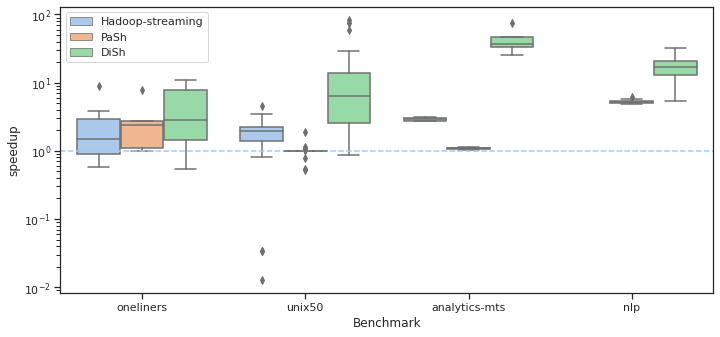

In [57]:
def boxplot(df, x, y, savefig=None, ax=None):
    f = sns.boxplot(data=df, x = x, y = y, hue="mode", ax=ax)
    f.set(yscale='log')
    plt.legend(loc='upper left')
    f.set(xlabel='Benchmark')
    f.axhline(1, ls='--')
    if savefig:
        plt.savefig(savefig)
        
benchmarks = ["oneliners", "unix50", "nlp", "analytics-mts"]
modes = ["seq", 'hadoopstreaming', "par", "distr"]
summary_per_mode = get_summary_per_mode(benchmarks, modes)
df1 = get_speedup_df(summary_per_mode)
boxplot(df1, x='benchmark', y='speedup', savefig="distr_boxplot.pdf")

Skipping executing dependency_untangling Sat Jun 11 23:46:46 UTC 2022
original_config/dependency_untangling/hadoopstreaming.res not found
Skipping executing dependency_untangling with pash Sun Jun 12 01:02:11 UTC 2022
Skipping executing dependency_untangling with pash Sun Jun 12 01:40:37 UTC 2022
Skipping executing max temp Sun Jun 12 01:45:57 UTC 2022
Skipping executing max-temp with par pash Sun Jun 12 02:20:31 UTC 2022
Skipping executing max-temp with distr pash Sun Jun 12 02:33:38 UTC 2022


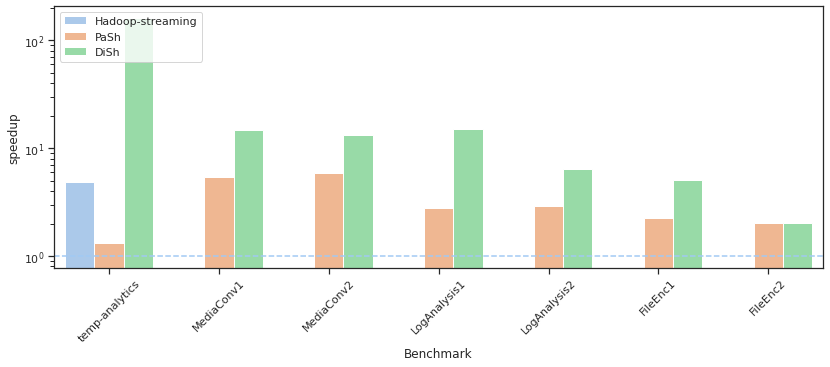

In [58]:
def speedup_barplot(df, x, y, savefig=None, ax=None):
    f = sns.barplot(data=df, x=x, y = y, hue="mode", ax=ax)
    f.set(xlabel='Benchmark')
    f.axhline(1, ls='--')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)
    plt.tight_layout()
    f.set(yscale='log')
    if savefig:
        plt.savefig(savefig)
        
benchmarks = ["dependency_untangling", "max-temp"]
modes = ["seq", "hadoopstreaming", "par", "distr"]
summary_per_mode = get_summary_per_mode(benchmarks, modes)
df2 = get_speedup_df(summary_per_mode)
speedup_barplot(df2, 'benchname', 'speedup', "par_vs_distr_barplot.pdf")

No handles with labels found to put in legend.


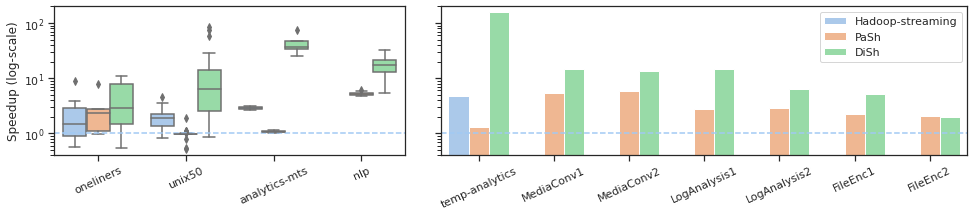

In [59]:
fig, ax = plt.subplots(1,2, sharey=True, gridspec_kw={'width_ratios': [2, 3]})
boxplot(df1, 'benchmark', 'speedup', None, ax[0])
ax[0].legend().set_visible(False)
speedup_barplot(df2, 'benchname', 'speedup', None, ax[1])
leg = plt.legend( loc = 'upper right')
# ax[1].legend().set(loc='upper right')
for axis in ax:
    axis.set(ylim=(0.4, 200))
    axis.set_xticklabels(axis.get_xticklabels(), rotation = 25)
    axis.set(xlabel=None)
    

ax[0].set(ylabel="Speedup (log-scale)")
ax[1].set(ylabel=None)
# ax[1].get_yaxis().set_ticks([])
ax[1].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
#     left=True,      # ticks along the bottom edge are off
    labelleft=False)

# fig.supxlabel('Benchmark')
fig.set_size_inches(14, 3, forward=True)

plt.tight_layout()


# fig.show()
plt.savefig("full_benchmarks_speedup.pdf")

Skipping executing Unix-for-nlp Sat Jun 11 14:01:48 UTC 2022
Skipping executing Unix-for-nlp with distr_no_du pash Sat Jun 11 22:07:06 UTC 2022
Skipping executing Unix-for-nlp with distr pash Sat Jun 11 22:54:28 UTC 2022
Skipping executing dependency_untangling Sat Jun 11 23:46:46 UTC 2022
Skipping executing dependency_untangling with pash Sun Jun 12 01:12:52 UTC 2022
Skipping executing dependency_untangling with pash Sun Jun 12 01:40:37 UTC 2022
Skipping executing max temp Sun Jun 12 01:45:57 UTC 2022
Skipping executing max-temp with distr_no_du pash Sun Jun 12 02:33:30 UTC 2022
Skipping executing max-temp with distr pash Sun Jun 12 02:33:38 UTC 2022


No handles with labels found to put in legend.


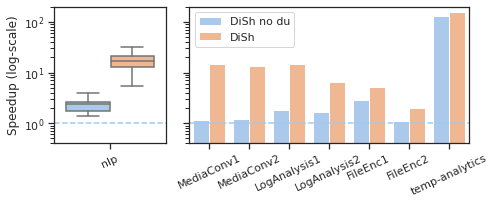

In [64]:
benchmarks = ["oneliners", "unix50", "nlp", "analytics-mts"]
modes = ["seq", "distr_no_du", "distr"]
summary_per_mode = get_summary_per_mode(["nlp"], modes)
df1_1 = get_speedup_df(summary_per_mode)

summary_per_mode = get_summary_per_mode(["dependency_untangling", "max-temp"], modes)
df2_1 = get_speedup_df(summary_per_mode)

fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [2, 5]})
boxplot(df1_1, 'benchmark', 'speedup', None, ax[0])
ax[0].legend().set_visible(False)
speedup_barplot(df2_1, 'benchname', 'speedup', None, ax[1])
# ax[0].legend().set_visible(False)

for axis in ax:
    axis.set(ylim=(0.4, 200))
    axis.set_xticklabels(axis.get_xticklabels(), rotation = 25)
    axis.set(xlabel=None)
    

ax[0].set(ylabel="Speedup (log-scale)")
ax[1].set(ylabel=None)
# ax[1].get_yaxis().set_ticks([])
ax[1].tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
#     left=True,      # ticks along the bottom edge are off
    labelleft=False)

# fig.supxlabel('Benchmark')

plt.tight_layout()

fig.set_size_inches(7, 3, forward=True)

plt.tight_layout()

# fig.show()
plt.savefig("dependency_untangling_speedup.pdf")